In [85]:
# import statements
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,learning_curve
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings("ignore")

In [86]:
# import dataset
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets.values.ravel()  # Flatten to 1D

In [87]:
# state
state = 257
# split the data
X_CV, X_LAST_TEST, y_CV, y_LAST_TEST = train_test_split(X, y, test_size=0.20, random_state=state)

In [88]:
# Neural Network
def nn_classification_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_classifier = KerasClassifier(model=nn_classification_model, verbose=0)

In [89]:
# Define Models
models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=state),
    "LogisticRegression": LogisticRegression(),
    "SVM": SVC(),
    "NeuralNetwork": nn_classifier,
    "RandomForest": RandomForestClassifier(random_state=state)
}

In [90]:
# Hyper Parameters
param_grids = {
    "KNN": {
        "model__n_neighbors": list(range(1, 13)),
        "model__metric": ["euclidean", "manhattan"],
        "model__weights": ["uniform", "distance"]
    },
    "DecisionTree": {
        "model__max_depth": [3, 5, 7, 9, None],
        "model__min_samples_split": [2, 5, 10, 15],
        "model__min_samples_leaf": [1, 5, 10]
    },
    "LogisticRegression": {
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "model__solver": ['newton-cg', 'lbfgs', 'liblinear']
    },
    "SVM": {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__kernel": ["rbf"],
        "model__gamma": ["scale", "auto"]
    },
    "NeuralNetwork": {
        "model__batch_size": [32, 64],
        "model__epochs": [50, 100]
    },
    "RandomForest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 4]
    },
}

In [91]:
# Accuracy
accuracy_scorer = make_scorer(accuracy_score)

# Cross-Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=state)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=state)

In [92]:
# Evaluating the Models
results = {}
best_model_name = None
best_accuracy = 0
best_final_model = None

for model_name, model in models.items():
    print(f"\nRunning Nested CV for {model_name}...")
    nested_scores = []

    for train_idx, test_idx in outer_cv.split(X_CV):
        X_train, X_test = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
        y_train, y_test = y_CV[train_idx], y_CV[test_idx]

        pipeline = ImbPipeline([
            ("smote", SMOTE(random_state=state)),
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],
            cv=inner_cv,
            scoring=accuracy_scorer,
            refit=True,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        nested_scores.append(score)

    mean_acc = np.mean(nested_scores)
    std_acc = np.std(nested_scores)

    results[model_name] = {"mean_accuracy": mean_acc, "std_accuracy": std_acc}

    if mean_acc > best_accuracy:
        best_accuracy = mean_acc
        best_model_name = model_name
        best_final_model = grid_search.best_estimator_

    print(f"{model_name} - Nested CV Accuracy Mean: {mean_acc:.4f}, Std: {std_acc:.4f}")

# Results Summary
print("\nFinal Nested Cross-Validation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: Mean Accuracy = {metrics['mean_accuracy']:.4f}, Std = {metrics['std_accuracy']:.4f}")

# Final Model
print(f"\nEvaluating best model ({best_model_name}) on holdout set...")
final_predictions = best_final_model.predict(X_LAST_TEST)
final_accuracy = accuracy_score(y_LAST_TEST, final_predictions)
print(f"Holdout Accuracy: {final_accuracy:.4f}")


Running Nested CV for KNN...
KNN - Nested CV Accuracy Mean: 0.9304, Std: 0.0085

Running Nested CV for DecisionTree...
DecisionTree - Nested CV Accuracy Mean: 0.9122, Std: 0.0091

Running Nested CV for LogisticRegression...
LogisticRegression - Nested CV Accuracy Mean: 0.9285, Std: 0.0104

Running Nested CV for SVM...
SVM - Nested CV Accuracy Mean: 0.9340, Std: 0.0066

Running Nested CV for NeuralNetwork...
NeuralNetwork - Nested CV Accuracy Mean: 0.9459, Std: 0.0057

Running Nested CV for RandomForest...
RandomForest - Nested CV Accuracy Mean: 0.9535, Std: 0.0094

Final Nested Cross-Validation Results:
KNN: Mean Accuracy = 0.9304, Std = 0.0085
DecisionTree: Mean Accuracy = 0.9122, Std = 0.0091
LogisticRegression: Mean Accuracy = 0.9285, Std = 0.0104
SVM: Mean Accuracy = 0.9340, Std = 0.0066
NeuralNetwork: Mean Accuracy = 0.9459, Std = 0.0057
RandomForest: Mean Accuracy = 0.9535, Std = 0.0094

Evaluating best model (RandomForest) on holdout set...
Holdout Accuracy: 0.9555


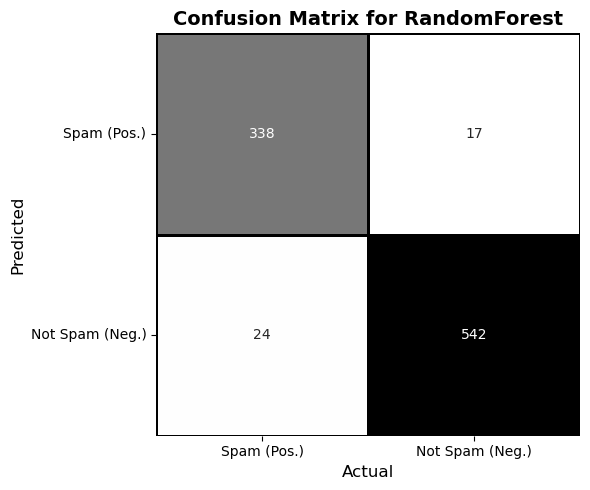

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       559
           1       0.95      0.93      0.94       362

    accuracy                           0.96       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.96      0.96      0.96       921



In [93]:
# Get confusion matrix: [[TN, FP], [FN, TP]]
cm = confusion_matrix(y_LAST_TEST, final_predictions)

# Rearrange to: [[TP, FP], [FN, TN]]
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

cm_custom = np.array([[TP, FP],
                      [FN, TN]])

# Plot numeric values inside cells
plt.figure(figsize=(6, 5))
sns.heatmap(cm_custom,
            annot=True,
            fmt='d',
            cmap="Greys",
            cbar=False,
            linewidths=1,
            linecolor='black',
            xticklabels=["Spam (Pos.)", "Not Spam (Neg.)"],
            yticklabels=["Spam (Pos.)", "Not Spam (Neg.)"])

# Titles and axis labels
plt.title(f"Confusion Matrix for {best_model_name}", fontsize=14, weight='bold')
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(classification_report(y_LAST_TEST, final_predictions))

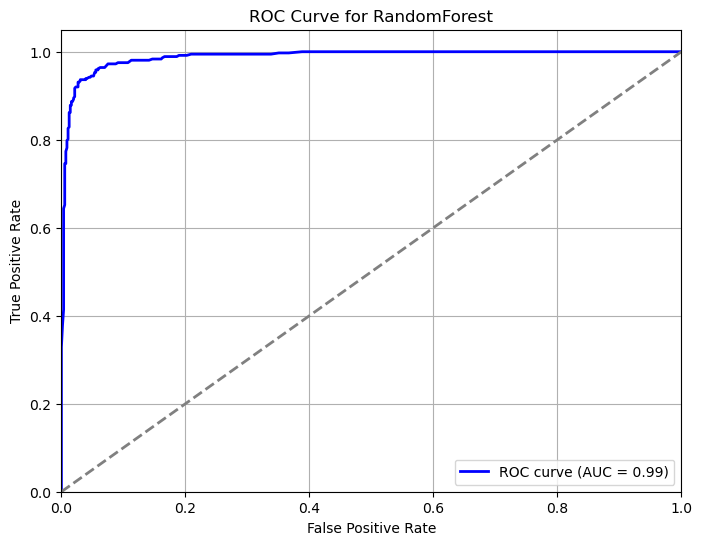

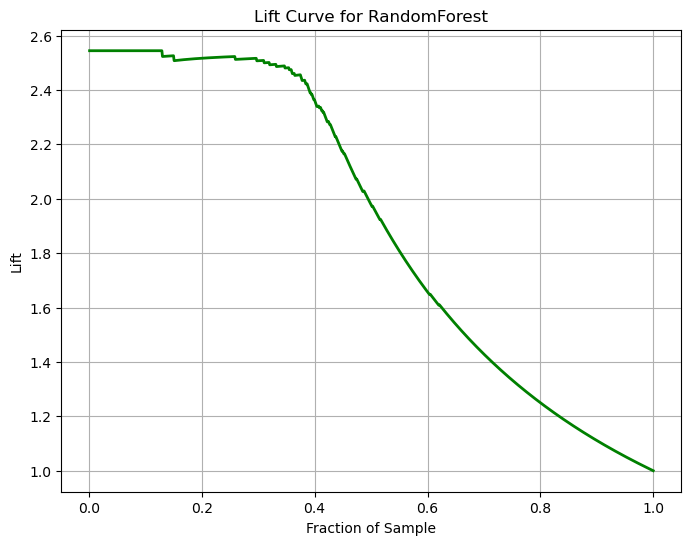

In [94]:
# Ensure y_LAST_TEST is in correct format
y_hold = y_LAST_TEST
x_hold_norm = StandardScaler().fit_transform(X_LAST_TEST)

# Get predicted probabilities for the positive class
if hasattr(best_final_model.named_steps["model"], "predict_proba"):
    y_pred_prob = best_final_model.predict_proba(X_LAST_TEST)[:, 1]
else:
    # Fallback for models that don’t support predict_proba (like SVM with default settings)
    y_pred_prob = best_final_model.decision_function(X_LAST_TEST)
    y_pred_prob = (y_pred_prob - y_pred_prob.min()) / (y_pred_prob.max() - y_pred_prob.min())  # Normalize to [0,1]

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_hold, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Lift Curve ---
# Sort by predicted probabilities (descending)
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_sorted = y_hold.iloc[sorted_indices] if isinstance(y_hold, pd.Series) else y_hold[sorted_indices]

# Calculate lift
cumulative_tp = np.cumsum(y_sorted)
lift = cumulative_tp / np.arange(1, len(y_sorted) + 1) / (np.sum(y_sorted) / len(y_sorted))

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(lift) + 1) / len(lift), lift, color='green', lw=2)
plt.xlabel('Fraction of Sample')
plt.ylabel('Lift')
plt.title(f'Lift Curve for {best_model_name}')
plt.grid(True)
plt.show()

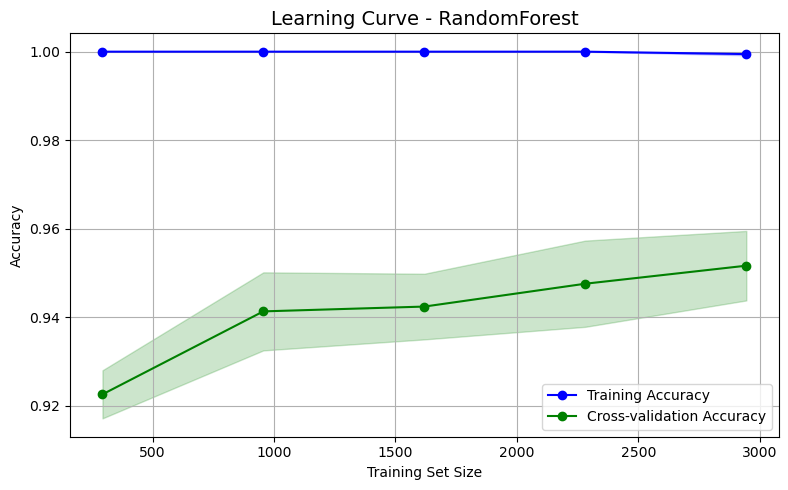

In [95]:
# Extract the trained model from the best pipeline
learning_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_final_model.named_steps["model"])
])

# Generate learning curves (classification, use accuracy)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=learning_pipeline,
    X=X_CV,
    y=y_CV,
    cv=KFold(n_splits=5, shuffle=True, random_state=state),
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Compute mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation Accuracy', color='green')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='green')

plt.title(f'Learning Curve - {best_model_name}', fontsize=14)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

MISCLASSIFICATION MODEL


Running Nested CV for KNN...
KNN - Avg Misclassification Cost: 0.54, Std: 0.08

Running Nested CV for DecisionTree...
DecisionTree - Avg Misclassification Cost: 0.58, Std: 0.05

Running Nested CV for LogisticRegression...
LogisticRegression - Avg Misclassification Cost: 0.44, Std: 0.04

Running Nested CV for SVM...
SVM - Avg Misclassification Cost: 0.41, Std: 0.05

Running Nested CV for NeuralNetwork...
NeuralNetwork - Avg Misclassification Cost: 0.26, Std: 0.08

Running Nested CV for RandomForest...
RandomForest - Avg Misclassification Cost: 0.30, Std: 0.06

Final Nested Cross-Validation Results:
KNN: Mean Cost = 0.54, Std = 0.08
DecisionTree: Mean Cost = 0.58, Std = 0.05
LogisticRegression: Mean Cost = 0.44, Std = 0.04
SVM: Mean Cost = 0.41, Std = 0.05
NeuralNetwork: Mean Cost = 0.26, Std = 0.08
RandomForest: Mean Cost = 0.30, Std = 0.06

Evaluating best model (NeuralNetwork) on holdout set...
Holdout Misclassification Cost: 0.33767643865363733


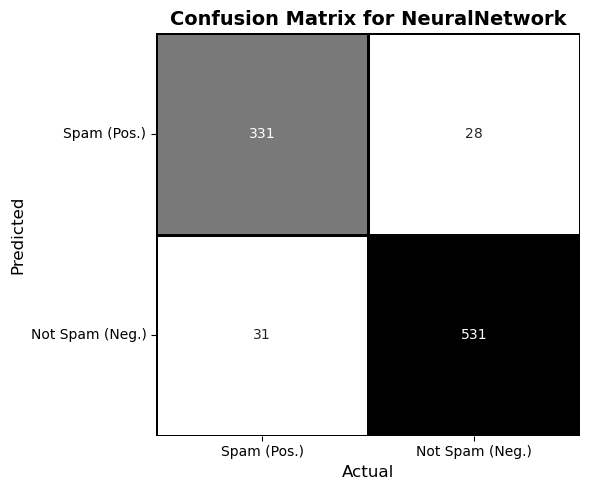

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       559
           1       0.92      0.91      0.92       362

    accuracy                           0.94       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.94      0.94      0.94       921



In [97]:
# Misclassification Cost
def misclassification_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0, 1]
    FN = cm[1, 0]
    return -(10 * FP + 1 * FN)/len(y_true)  # Negative for minimization

cost_scorer = make_scorer(misclassification_cost, greater_is_better=False)

# # Cross-Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=state)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=state)

# # Evaluating the Models
results = {}
best_model_name = None
best_cost = float('inf')
best_final_model = None

for model_name, model in models.items():
    print(f"\nRunning Nested CV for {model_name}...")
    nested_costs = []

    for train_idx, test_idx in outer_cv.split(X_CV):
        X_train, X_test = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
        y_train, y_test = y_CV[train_idx], y_CV[test_idx]

        pipeline = ImbPipeline([
            ("smote", SMOTE(random_state=state)),
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],
            cv=inner_cv,
            scoring=cost_scorer,
            refit=True,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        cost = -misclassification_cost(y_test, y_pred)  # Flip sign back
        nested_costs.append(cost)

    mean_cost = np.mean(nested_costs)
    std_cost = np.std(nested_costs)

    results[model_name] = {"mean_cost": mean_cost, "std_cost": std_cost}

    if mean_cost < best_cost:
        best_cost = mean_cost
        best_model_name = model_name
        best_final_model = grid_search.best_estimator_

    print(f"{model_name} - Avg Misclassification Cost: {mean_cost:.2f}, Std: {std_cost:.2f}")

# Results Summary
print("\nFinal Nested Cross-Validation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: Mean Cost = {metrics['mean_cost']:.2f}, Std = {metrics['std_cost']:.2f}")

# Final Model
print(f"\nEvaluating best model ({best_model_name}) on holdout set...")
final_predictions = best_final_model.predict(X_LAST_TEST)
final_cm = confusion_matrix(y_LAST_TEST, final_predictions)
FP = final_cm[0, 1]
FN = final_cm[1, 0]
final_cost = (10 * FP + 1 * FN)/len(y_LAST_TEST)
print(f"Holdout Misclassification Cost: {final_cost}")

# Get confusion matrix: [[TN, FP], [FN, TP]]
cm = confusion_matrix(y_LAST_TEST, final_predictions)

# Rearrange to: [[TP, FP], [FN, TN]]
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

cm_custom = np.array([[TP, FP],
                      [FN, TN]])

# Plot numeric values inside cells
plt.figure(figsize=(6, 5))
sns.heatmap(cm_custom,
            annot=True,
            fmt='d',
            cmap="Greys",
            cbar=False,
            linewidths=1,
            linecolor='black',
            xticklabels=["Spam (Pos.)", "Not Spam (Neg.)"],
            yticklabels=["Spam (Pos.)", "Not Spam (Neg.)"])

# Titles and axis labels
plt.title(f"Confusion Matrix for {best_model_name}", fontsize=14, weight='bold')
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(classification_report(y_LAST_TEST, final_predictions))

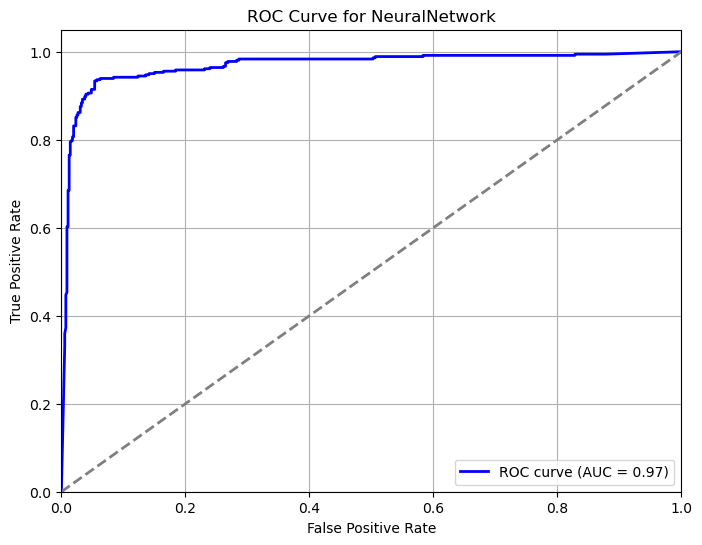

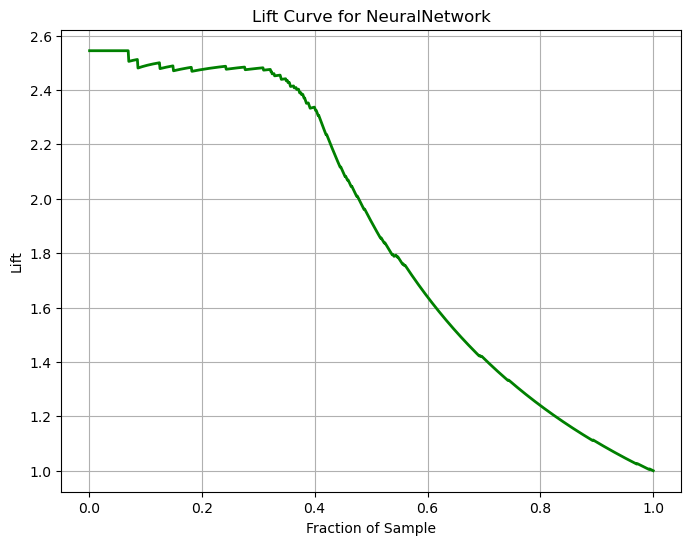

In [98]:
# Ensure y_LAST_TEST is in correct format
y_hold = y_LAST_TEST
x_hold_norm = StandardScaler().fit_transform(X_LAST_TEST)

# Get predicted probabilities for the positive class
if hasattr(best_final_model.named_steps["model"], "predict_proba"):
    y_pred_prob = best_final_model.predict_proba(X_LAST_TEST)[:, 1]
else:
    # Fallback for models that don’t support predict_proba (like SVM with default settings)
    y_pred_prob = best_final_model.decision_function(X_LAST_TEST)
    y_pred_prob = (y_pred_prob - y_pred_prob.min()) / (y_pred_prob.max() - y_pred_prob.min())  # Normalize to [0,1]

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_hold, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Lift Curve ---
# Sort by predicted probabilities (descending)
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_sorted = y_hold.iloc[sorted_indices] if isinstance(y_hold, pd.Series) else y_hold[sorted_indices]

# Calculate lift
cumulative_tp = np.cumsum(y_sorted)
lift = cumulative_tp / np.arange(1, len(y_sorted) + 1) / (np.sum(y_sorted) / len(y_sorted))

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(lift) + 1) / len(lift), lift, color='green', lw=2)
plt.xlabel('Fraction of Sample')
plt.ylabel('Lift')
plt.title(f'Lift Curve for {best_model_name}')
plt.grid(True)
plt.show()

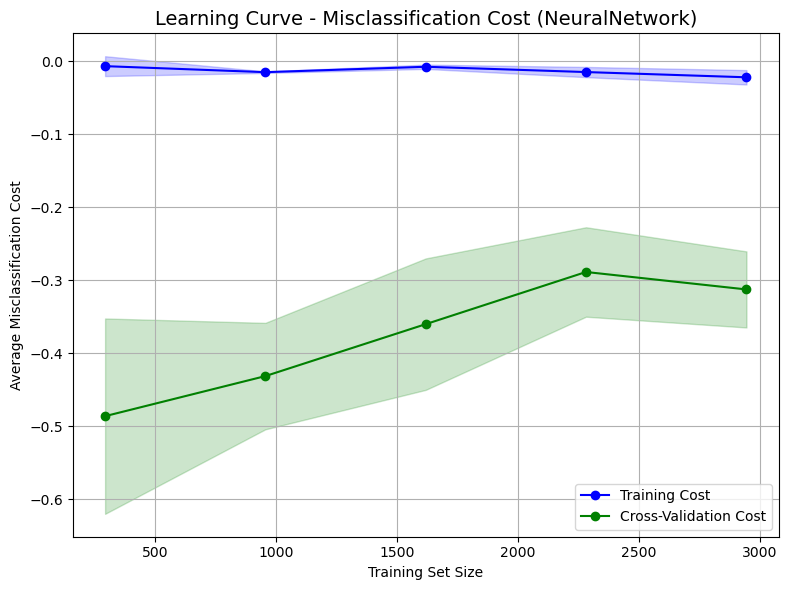

In [99]:
# Rebuild best model pipeline (including SMOTE and scaler) for learning curve
learning_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=state)),
    ("scaler", StandardScaler()),
    ("model", best_final_model.named_steps["model"])
])

# Learning curve with misclassification cost
train_sizes, train_scores, val_scores = learning_curve(
    estimator=learning_pipeline,
    X=X_CV,
    y=y_CV,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=KFold(n_splits=5, shuffle=True, random_state=state),
    scoring=cost_scorer,  # Using average misclassification cost
    n_jobs=-1
)

# Convert negative costs back to positive
train_cost_mean = -np.mean(train_scores, axis=1)
train_cost_std = np.std(train_scores, axis=1)
val_cost_mean = -np.mean(val_scores, axis=1)
val_cost_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_cost_mean, 'o-', color='blue', label='Training Cost')
plt.fill_between(train_sizes, train_cost_mean - train_cost_std, train_cost_mean + train_cost_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_cost_mean, 'o-', color='green', label='Cross-Validation Cost')
plt.fill_between(train_sizes, val_cost_mean - val_cost_std, val_cost_mean + val_cost_std, alpha=0.2, color='green')

plt.title(f'Learning Curve - Misclassification Cost ({best_model_name})', fontsize=14)
plt.xlabel('Training Set Size')
plt.ylabel('Average Misclassification Cost')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


WRITE UP

I started by defining six different models: KNN, Decision Tree, Logistic Regression, SVM, Neural Network, and Random Forest. I initially included XGBoost, but my computer had difficulty running it, so I decided to drop it. These models provided a variety of classification methods that I could use to determine the best model for predicting spam and not-spam emails.

The dataset was split into training and testing sets, and nested cross-validation was used to help avoid potential overfitting. Each model was given approximately three different hyperparameters for tuning. This added an extra layer of depth to each model, which helped improve accuracy. Additionally, the data was normalized to reduce the impact of outliers during model training. Because the dataset had roughly 61 percent not spam and 39 percent spam, I implemented SMOTE as an oversampling technique to help build a more balanced and representative model.

All models achieved an accuracy score above 90 percent, but only the Random Forest model scored above 95 percent, with an accuracy of 95.55 percent. The positive class had a precision of 95 percent and a recall of 93 percent, with an F1 score of 94 percent. The ROC curve was nearly perfect, with an AUC of 0.99. The lift curve hovered around 2.5 and did not drop until about 40 percent, showing that the top 40 percent of samples contained 2.5 times more positives than a random selection.

For the misclassification models, I used the same techniques as above but evaluated each model based on the average misclassification cost. False positives were assigned a cost of 10, and false negatives a cost of 1. The reason false positives had a higher cost is that if a non-spam email is incorrectly sent to the spam folder, the user might miss important information. On the other hand, if spam ends up in the inbox, the user can simply move it manually.

The Neural Network model had the best performance, and the lowest average misclassification cost after the final evaluation was 0.34, meaning each error cost about 34 cents on average. The precision of this model was lower than the accuracy-evaluated model (92 percent compared to 95 percent), recall was lower (91 percent compared to 93 percent), and the F1 score was also lower (92 percent compared to 94 percent). 

Finally, the ROC curve followed a similar pattern to the previous model, though the AUC was slightly lower at 0.97. The lift curve showed that the top 30 percent of samples contained approximately 2.5 times more positives than would be expected at random.
